# Branches

Branch pipelines are **linear secondary pipelines** that origin either from the primary dataframe or from a dataframe fetched from the Nebula Storage.

The input dataframe and the way that they are merged back (if requested) to the main flow depends on the “branch” configuration.

**The main flow/dataframe remains unchanged.**

In [1]:
import polars as pl

from nebula.base import Transformer
from nebula.transformers import *
from nebula.storage import nebula_storage as ns
from nebula.pipelines.pipeline import TransformerPipeline
from nebula.pipelines.pipeline_loader import load_pipeline

%load_ext autoreload
%autoreload 2

To create a **branch** in a pipeline, you’ll need to define a **dictionary** that specifies the input and how to merge it back into the main pipeline. 

Let’s break it down!

### **Input** Definition:<br>
- If the key `storage` is defined, the input for the branch will be the value associated with this key.<br>
- If “storage” is not defined, the input will be a copy of the primary dataframe. The original dataframe will remain untouched.

![title](branch_df_input.jpg)

### **Output** Definition:<br>
At the end of the pipeline, there are three possible scenarios based on the `end` value:
- `"end": "dead-end"`: the dataframe will not be merged back.<br>
- `"end": "append"`: the dataframe will be appended to the main one.<br>
- `"end": "append", "on": ..., "how": ...`the dataframe will be joined to the primary one using the provided `on` and `how` parameters.

![title](branch_df_output.jpg)

### Let's see all the possible combinations!

- **Input:** from storage
- **Output:** dead-end

In [2]:
df_input = pl.DataFrame({
        "idx": [0, 1, 2, 3, 4, 5],
        "c1": ["a", "b", "c", "d", "e", "f"],
        "c2": ["x", "y", "z", "w", "v", "u"],
    })

# Store DataFrame with subset of idx values
df_source = pl.DataFrame({
    "idx": [0, 1, 2],  # Only 3 of 6 idx values
    "c1": ["x", "y", "z"],
    "c2": ["a", "b", "c"],
})
ns.set("df_source", df_source)

pipe = TransformerPipeline(
        [
            DropColumns(columns=["c1", "c2"]),
            AddLiterals(data=[{"value": "joined_from_storage", "alias": "new_col"}]),
        ],
        branch={
            "storage": "df_source",
            "end": "join",
            "on": "idx",
            "how": "inner",
        },
        otherwise=AssertNotEmpty()
    )

pipe.show(add_params=True)

2025-12-25 05:03:24,932 | [INFO]: Nebula Storage: setting an object (<class 'polars.dataframe.frame.DataFrame'>) with the key "df_source". 


*** Pipeline *** (3 transformations)
------ BRANCH (from storage: df_source) ------
  - end: join
>> Branch (2 transformations):
     - DropColumns -> PARAMS: columns=['c1', 'c2']
     - AddLiterals -> PARAMS: data=[{'value': 'joined_from_storage', 'alias': 'new_col'}]
>> Otherwise (1 transformation)
     - AssertNotEmpty
<<< Join DFs >>>
  - how: inner
  - on: idx


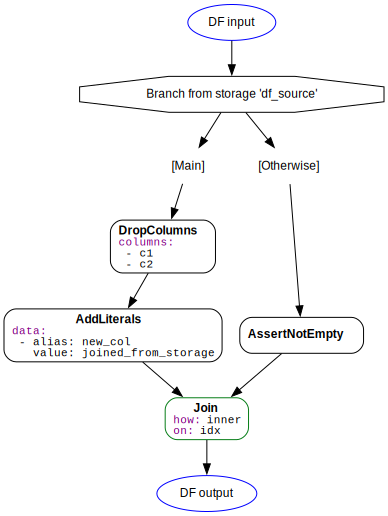

In [3]:
pipe.plot(add_params=True)

In [4]:
df_out = pipe.run(df_input, show_params=True)
df_out

2025-12-25 05:03:26,775 | [INFO]: Starting pipeline 
2025-12-25 05:03:26,776 | [INFO]: Entering branch 
2025-12-25 05:03:26,777 | [INFO]: Running 'DropColumns' PARAMS: columns=['c1', 'c2'] ... 
2025-12-25 05:03:26,801 | [INFO]: Completed 'DropColumns' in 0.0s 
2025-12-25 05:03:26,802 | [INFO]: Running 'AddLiterals' PARAMS: data=[{'value': 'joined_from_storage', 'alias': 'new_col'}] ... 
2025-12-25 05:03:26,805 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-25 05:03:26,806 | [INFO]: Running 'AssertNotEmpty' ... 
2025-12-25 05:03:26,807 | [INFO]: Completed 'AssertNotEmpty' in 0.0s 
2025-12-25 05:03:26,826 | [INFO]: Pipeline completed in 0.1s 


idx,c1,c2,new_col
i64,str,str,str
0,"""a""","""x""","""joined_from_storage"""
1,"""b""","""y""","""joined_from_storage"""
2,"""c""","""z""","""joined_from_storage"""
